## CSP using the library generator based on element substitution

The demonstration show how to predict the structure of a compound only from its chemical composition. As we described in our paper, the workflow can be divided into four parts:

1. Find all possible template structures from a crystal structure database (Materials Project was used in this study).
2. Repalce elements in the templates with the query composition to generate a virtual structure library.
3. Learn a surrogate model to evaluate the energies of virtual structures to filter the candidate.
4. Perform structure relaxation on the candidate and rank them by calculated energy ascending to propose the final structures.

All these codes are developed with Python 3.7 and [XenonPy](https://github.com/yoshida-lab/XenonPy) and have already been tested with Python 3.7, 3.8, and 3.9. A DFT calculation backend is also needed to execute single-point and structure relaxation calculations mentioned below. In this study, [Vienna Ab initio Simulation Package (ak. VASP)](https://www.vasp.at/) was introduced to cover this work.

Please download the necessary files to run this demonstration.  All files should be organized as follows.

```
├── CSP_with_element_substitution.ipynb
├── cgcnn_formation_energy
│   ├── checkpoints
│   │   ├── mae.pth.s
│   │   ├── mse.pth.s
│   │   ├── pearsonr.pth.s
│   │   └── r2.pth.s
│   ├── data_indices.pkl.z
│   ├── describe.pkl.z
│   ├── final_state.pth.s
│   ├── ft_training_plot.png
│   ├── ft_training_steps.png
│   ├── init_state.pth.s
│   ├── model.pth.m
│   ├── model_class.pkl.z
│   ├── model_params.pkl.z
│   ├── model_structure.pkl.z
│   ├── results.csv
│   ├── results.pd.xz
│   ├── training_info.pd.xz
│   └── val_idx.pkl.z
├── data
│   ├── mp_structures_info.pd.xz
│   └── searching_targets_with_predictions.pd.xz
└── generated
    ├── opt_candidate_result.pd.xz
    └── single_point_results.pd.xz
```

* cgcnn_formation_energy: https://github.com/yoshida-lab/XenonPy/releases/download/v0.6.7/cgcnn_formation_energy.tar.gz
* data: https://github.com/yoshida-lab/XenonPy/releases/download/v0.6.7/data.tar.gz
* generated: https://github.com/yoshida-lab/XenonPy/releases/download/v0.6.7/generated.tar.gz

#### Common packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import json
import operator

from pathlib import Path
from functools import reduce
from collections import defaultdict


from pymatgen.core import Structure, Element, Composition
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
from joblib import Parallel, delayed, load
from tqdm.notebook import tqdm


# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 1. Load data

In this study, we compiled a list containing 90 stable crystalline compounds as the benchmark set (see our paper for details). All structures in the Materials Project database will be used as template pool.

In [2]:
# the benchmark set used in our paper
searching_targets = pd.read_pickle('data/searching_targets_with_predictions.pd.xz')

# template structures
mp_structs_info = pd.read_pickle('data/mp_structures_info.pd.xz')
mp_structs_info = mp_structs_info.assign(structure=mp_structs_info.structure.apply(lambda s: Structure.from_dict(s)))

searching_targets.head(3)
mp_structs_info.head(3)
mp_structs_info.shape

,composition,elements,n_elemets,n_atoms,pretty_formula,space_group,space_group_number,volume,structure,full_formula,formation_energy,dataset,pred_volume,pred_spg,pred_spg_top20,rank
mp-569304,{'C': 4.0},[C],1,4,C,R-3m,166,62.601036,"[[ 3.48460258 2.02633463 33.51650787] C, [1.0...",C4,0.000000,1,14.695088,166,"[166, 64, 194, 15, 62, 8, 160, 225, 221, 74, 1...",0
mp-149,{'Si': 2.0},[Si],1,2,Si,Fd-3m,227,40.888293,"[[1.11629943 0.7893429 1.93348733] Si, [0. 0....",Si2,0.000000,1,33.270061,225,"[225, 227, 189, 194, 200, 129, 216, 191, 11, 1...",1
mp-2534,"{'Ga': 1.0, 'As': 1.0}","[Ga, As]",2,2,GaAs,F-43m,216,47.531857,"[[0. 0. 0.] Ga, [3.52125296 2.48990185 6.09898...",Ga1As1,-0.347249,1,41.831081,216,"[216, 225, 160, 187, 166, 14, 5, 194, 44, 156,...",0


,full_formula,composition,composition_ratio,total_atoms,elements,n_elements,space_group_num,space_group,wy_cfg,wy_reformat,wy_pattern,wy_pattern_loose,wy_unique,ss_cfg,ss_reformat,ss_pattern,ss_pattern_loose,ss_unique,volume_of_cell,structure
id,,,,,,,,,,,,,,,,,,,,
mp-10018,Ac1,{'Ac': 1.0},"(1.0,)",1.0,"(Ac,)",1,225,Fm-3m,{'Ac': {'a': 4}},"{'Ac': ('a',)}","((a,),)","(a,)","(a,)",{'Ac': {'m-3m': 4}},"{'Ac': ('m-3m',)}","((m-3m,),)","(m-3m,)","(m-3m,)",45.384600,[[0. 0. 0.] Ac]
mp-1006278,Ac1Eu1Au2,"{'Ac': 1.0, 'Eu': 1.0, 'Au': 2.0}","(1.0, 1.0, 2.0)",4.0,"(Ac, Au, Eu)",3,225,Fm-3m,"{'Ac': {'b': 4}, 'Eu': {'a': 4}, 'Au': {'c': 8}}","{'Ac': ('b',), 'Eu': ('a',), 'Au': ('c',)}","((a,), (b,), (c,))","(a, b, c)","(a, b, c)","{'Ac': {'m-3m': 4}, 'Eu': {'m-3m': 4}, 'Au': {...","{'Ac': ('m-3m',), 'Eu': ('m-3m',), 'Au': ('-43...","((-43m,), (m-3m,), (m-3m,))","(-43m, m-3m, m-3m)","(-43m, m-3m)",117.080578,"[[3.882859 3.882859 3.882859] Ac, [0. 0. 0.] E..."
mp-1008601,Zr1Ag2,"{'Zr': 1.0, 'Ag': 2.0}","(1.0, 2.0)",3.0,"(Ag, Zr)",2,139,I4/mmm,"{'Zr': {'a': 2}, 'Ag': {'e': 4}}","{'Zr': ('a',), 'Ag': ('e',)}","((a,), (e,))","(a, e)","(a, e)","{'Zr': {'4/mmm': 2}, 'Ag': {'4mm': 4}}","{'Zr': ('4/mmm',), 'Ag': ('4mm',)}","((4/mmm,), (4mm,))","(4/mmm, 4mm)","(4/mmm, 4mm)",58.128751,"[[0. 0. 0.] Zr, [0. 0. 6.08155..."


(126300, 20)

To simplify this demonstration, we chose $\mathrm{Zr}\mathrm{O}_2$ as an example to show how to reproduce our results.

In [3]:
demo_target = 'ZrO2'

demo_target = searching_targets[searching_targets.pretty_formula==demo_target]
demo_target

,composition,elements,n_elemets,n_atoms,pretty_formula,space_group,space_group_number,volume,structure,full_formula,formation_energy,dataset,pred_volume,pred_spg,pred_spg_top20,rank
mp-2858,"{'Zr': 4.0, 'O': 8.0}","[Zr, O]",2,12,ZrO2,P2_1/c,14,147.110401,"[[0.23276056 1.42220345 4.53138565] Zr, [2.401...",Zr4O8,-3.83322,1,140.843399,14,"[14, 167, 87, 59, 189, 136, 141, 12, 92, 198, ...",0


Drop the `demo_target` from the template pool.

In [4]:
templates = mp_structs_info.loc[~mp_structs_info.index.isin(demo_target.index)]

templates.shape
templates.head(3)

(126299, 20)

,full_formula,composition,composition_ratio,total_atoms,elements,n_elements,space_group_num,space_group,wy_cfg,wy_reformat,wy_pattern,wy_pattern_loose,wy_unique,ss_cfg,ss_reformat,ss_pattern,ss_pattern_loose,ss_unique,volume_of_cell,structure
id,,,,,,,,,,,,,,,,,,,,
mp-10018,Ac1,{'Ac': 1.0},"(1.0,)",1.0,"(Ac,)",1,225,Fm-3m,{'Ac': {'a': 4}},"{'Ac': ('a',)}","((a,),)","(a,)","(a,)",{'Ac': {'m-3m': 4}},"{'Ac': ('m-3m',)}","((m-3m,),)","(m-3m,)","(m-3m,)",45.384600,[[0. 0. 0.] Ac]
mp-1006278,Ac1Eu1Au2,"{'Ac': 1.0, 'Eu': 1.0, 'Au': 2.0}","(1.0, 1.0, 2.0)",4.0,"(Ac, Au, Eu)",3,225,Fm-3m,"{'Ac': {'b': 4}, 'Eu': {'a': 4}, 'Au': {'c': 8}}","{'Ac': ('b',), 'Eu': ('a',), 'Au': ('c',)}","((a,), (b,), (c,))","(a, b, c)","(a, b, c)","{'Ac': {'m-3m': 4}, 'Eu': {'m-3m': 4}, 'Au': {...","{'Ac': ('m-3m',), 'Eu': ('m-3m',), 'Au': ('-43...","((-43m,), (m-3m,), (m-3m,))","(-43m, m-3m, m-3m)","(-43m, m-3m)",117.080578,"[[3.882859 3.882859 3.882859] Ac, [0. 0. 0.] E..."
mp-1008601,Zr1Ag2,"{'Zr': 1.0, 'Ag': 2.0}","(1.0, 2.0)",3.0,"(Ag, Zr)",2,139,I4/mmm,"{'Zr': {'a': 2}, 'Ag': {'e': 4}}","{'Zr': ('a',), 'Ag': ('e',)}","((a,), (e,))","(a, e)","(a, e)","{'Zr': {'4/mmm': 2}, 'Ag': {'4mm': 4}}","{'Zr': ('4/mmm',), 'Ag': ('4mm',)}","((4/mmm,), (4mm,))","(4/mmm, 4mm)","(4/mmm, 4mm)",58.128751,"[[0. 0. 0.] Zr, [0. 0. 6.08155..."


### 2. Filter templates

In [5]:
# help functions to calculate dissimilarity and refine structures

from matminer.featurizers.site import CrystalNNFingerprint
from matminer.featurizers.structure import SiteStatsFingerprint
from joblib import Parallel, delayed

def calculate_similarity(anchor_struc, *struc, n_jobs=10):
    # Calculate structure fingerprints.
    ssf = SiteStatsFingerprint(
        CrystalNNFingerprint.from_preset('ops', distance_cutoffs=None, x_diff_weight=0),
        stats=('mean', 'std_dev', 'minimum', 'maximum'))
    v_anchor = np.array(ssf.featurize(anchor_struc))
    tmp = Parallel(n_jobs=n_jobs)(delayed(ssf.featurize)(s) for s in struc)
    return [np.linalg.norm(np.array(s) - v_anchor) for s in tmp]

def modify_struct(s: Structure, vol=None) -> Structure:
    s = s.get_primitive_structure()
    if vol is not None:
        s.scale_lattice(vol)
    return s

For a given query composition $\mathrm{Zr}\mathrm{O}_2$, we collected a set of template crystal structures with the same compositional ratio from the Materials Project database. 

In [6]:
demo_target = demo_target.iloc[0]

# general info
full_formula = demo_target.full_formula
volume = demo_target.pred_volume
spg_num = demo_target.space_group_number

# composition info
composition = demo_target.composition
composition_ratio = tuple(sorted([v for v in composition.values()]))

# groundtruth
true_struct = demo_target.structure
if spg_num not in [146, 148, 155, 160, 161, 166, 167]:
    true_struct = SpacegroupAnalyzer(true_struct).get_conventional_standard_structure()

Filter templates from pool

In [7]:
filtered_templates = mp_structs_info[(mp_structs_info.composition_ratio == composition_ratio) & (mp_structs_info.composition != composition)]
filtered_templates = filtered_templates.assign(
    structure=filtered_templates.structure.apply(lambda s: modify_struct(s, vol=volume)),
    volume_of_cell=[volume] * filtered_templates.shape[0],
)

filtered_templates.shape
filtered_templates.head(3)

(924, 20)

,full_formula,composition,composition_ratio,total_atoms,elements,n_elements,space_group_num,space_group,wy_cfg,wy_reformat,wy_pattern,wy_pattern_loose,wy_unique,ss_cfg,ss_reformat,ss_pattern,ss_pattern_loose,ss_unique,volume_of_cell,structure
id,,,,,,,,,,,,,,,,,,,,
mp-1093999,Zn8Ag4,"{'Zn': 8.0, 'Ag': 4.0}","(4.0, 8.0)",12.0,"(Ag, Zn)",2,194,P6_3/mmc,"{'Zn': {'a': 2, 'h': 6}, 'Ag': {'f': 4}}","{'Zn': ('a', 'h'), 'Ag': ('f',)}","((a, h), (f,))","(a, f, h)","(a, f, h)","{'Zn': {'-3m.': 2, 'mm2': 6}, 'Ag': {'3m.': 4}}","{'Zn': ('mm2', '-3m.'), 'Ag': ('3m.',)}","((3m.,), (mm2, -3m.))","(-3m., 3m., mm2)","(-3m., 3m., mm2)",140.843399,"[[0. 0. 0.] Zn, [0. 0. 3.78643..."
mp-1094121,Mg4Ag8,"{'Mg': 4.0, 'Ag': 8.0}","(4.0, 8.0)",12.0,"(Ag, Mg)",2,194,P6_3/mmc,"{'Mg': {'f': 4}, 'Ag': {'a': 2, 'h': 6}}","{'Mg': ('f',), 'Ag': ('a', 'h')}","((a, h), (f,))","(a, f, h)","(a, f, h)","{'Mg': {'3m.': 4}, 'Ag': {'-3m.': 2, 'mm2': 6}}","{'Mg': ('3m.',), 'Ag': ('-3m.', 'mm2')}","((-3m., mm2), (3m.,))","(-3m., 3m., mm2)","(-3m., 3m., mm2)",140.843399,"[[2.34438871 1.35353592 0.45181891] Mg, [ 2.34..."
mp-1095654,Si4Ag8,"{'Si': 4.0, 'Ag': 8.0}","(4.0, 8.0)",12.0,"(Ag, Si)",2,63,Cmcm,"{'Si': {'f': 8}, 'Ag': {'a': 4, 'c': 4, 'g': 8}}","{'Si': ('f',), 'Ag': ('a', 'c', 'g')}","((a, c, g), (f,))","(a, c, f, g)","(a, c, f, g)","{'Si': {'m..': 8}, 'Ag': {'2/m..': 4, 'm2m': 4...","{'Si': ('m..',), 'Ag': ('..m', 'm2m', '2/m..')}","((..m, 2/m.., m2m), (m..,))","(..m, 2/m.., m.., m2m)","(..m, 2/m.., m.., m2m)",140.843399,"[[ 2.35634937 -1.37790624 6.65122564] Si, [2...."


Perform postprocess to add dissimilarity and other information

<Axes: ylabel='Frequency'>

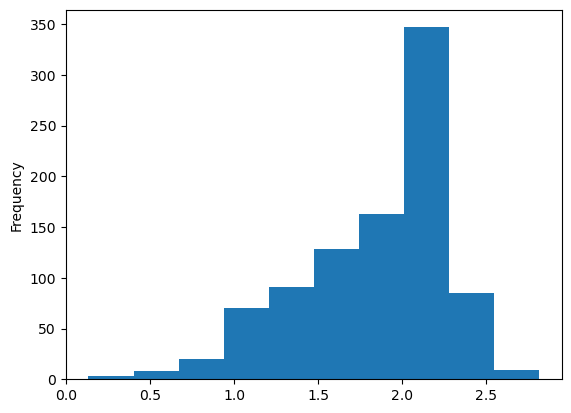

In [8]:
filtered_templates = filtered_templates.assign(
    dissimilarity=calculate_similarity(true_struct, *filtered_templates.structure),
    target_formula=[full_formula] * filtered_templates.shape[0],
    target_space_group_num=[spg_num] * filtered_templates.shape[0]
).sort_values('dissimilarity')

filtered_templates.dissimilarity.plot.hist()

Considering that multiple crystals in the database belong to the same prototype structure (for example, 8,005 compounds have the same composition ratio A$_1$B$_1$C$_2$), a cluster-based template selection procedure was introduced. The objective is to select highly relevant templates with query composition $\mathrm{Zr}\mathrm{O}_2$ while maintaining the diversity of the template structures. We applied DBSCAN to classify the templates into clusters in which the chemical compositions were converted into 290-dimensional compositional descriptors using XenonPy. Only the templates belonging to the same cluster as $\mathrm{Zr}\mathrm{O}_2$ were selected.

In [9]:
from xenonpy.descriptor import Compositions
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

desc_cal = Compositions()

# Compute DBSCAN
comps = filtered_templates.composition
comps['target'] = demo_target.composition
desc = desc_cal.fit_transform(comps)
X = StandardScaler().fit_transform(desc)

db = DBSCAN(eps=9, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('  Target class number: %d' % labels[-1])
print('  Estimated number of clusters: %d' % n_clusters_)
print('  Estimated number of noise points: %d' % n_noise_)

/tmp/ipykernel_615149/482518645.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comps['target'] = demo_target.composition


  Target class number: 0
  Estimated number of clusters: 12
  Estimated number of noise points: 384


(89, 23)

<Axes: ylabel='Frequency'>

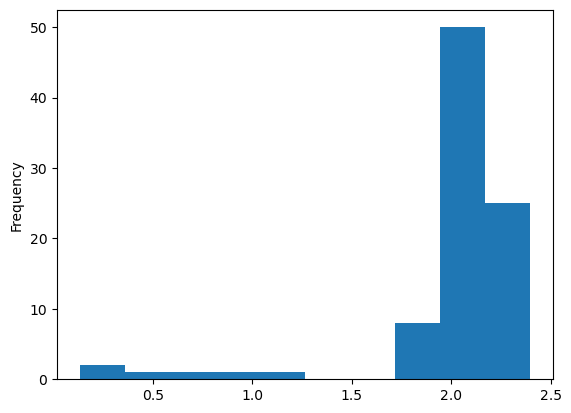

In [10]:
target_label = labels[-1]
template_labels = labels[:-1]

structs_ = filtered_templates.iloc[template_labels == target_label]
structs_.shape
structs_.dissimilarity.plot.hist()

In addition, to eliminate structurally redundant templates, we used pymatgen's StructureMatcher module to construct a unique set of templates that did not contain identical prototype structures.

for spg: 1, size: 3
for spg: 2, size: 7
for spg: 4, size: 1
for spg: 10, size: 2
for spg: 11, size: 1
for spg: 12, size: 9
for spg: 14, size: 3
for spg: 15, size: 2
for spg: 18, size: 1
for spg: 29, size: 1
for spg: 44, size: 1
for spg: 60, size: 4
for spg: 62, size: 10
for spg: 63, size: 8
for spg: 70, size: 2
for spg: 74, size: 6
for spg: 87, size: 6
for spg: 88, size: 1
for spg: 111, size: 1
for spg: 141, size: 1
for spg: 160, size: 7
for spg: 205, size: 6
for spg: 227, size: 6


(44, 4)

,structure,composition,space_group_num,dissimilarity
0,"[[2.82319719 4.36285554 3.72176206] Hf, [0.222...","{'Hf': 4.0, 'O': 8.0}",14,0.130907
1,"[[1.3678768 1.24913405 0.18071245] Hf, [1.367...","{'Hf': 4.0, 'O': 8.0}",29,0.494103
2,"[[3.67241649 1.45548662 1.50319392] Hf, [1.371...","{'Hf': 4.0, 'O': 8.0}",18,0.636794


<Axes: ylabel='Frequency'>

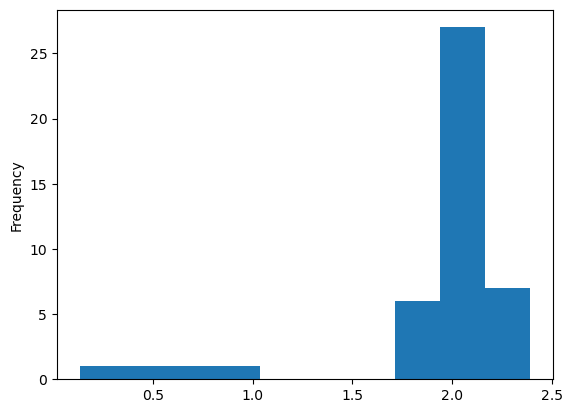

In [11]:
from pymatgen.analysis.structure_matcher import StructureMatcher

matcher = StructureMatcher(ltol=0.05, angle_tol=3)

ret = []
for spg_num_, ss in structs_.groupby('space_group_num'):
    print(f'for spg: {spg_num_}, size: {ss.shape[0]}')
    cand_structs = ss.structure

    # final condidate
    cand_structs = matcher.group_structures(cand_structs, anonymous=True)
    for s in cand_structs:
        ret.append([s[0]])

if len(ret) == 0:
    print('No templates')
ret = pd.DataFrame(ret, columns=['structure'])
filtered_templates = ret.assign(
    composition=ret.structure.apply(lambda s: dict(s.composition.as_dict())),
    space_group_num=ret.structure.apply(lambda s: s.get_space_group_info()[1]),
    dissimilarity=calculate_similarity(true_struct, *ret.structure),
).sort_values('dissimilarity').reset_index(drop=True)

filtered_templates.shape
filtered_templates.head(3)
filtered_templates.dissimilarity.plot.hist()

Save templates for reusing.

In [12]:
filtered_templates.to_pickle('generated/filtered_templates.pd.xz')

### 3. Element substitution

In [13]:
from xenonpy.datatools import preset

elem_info = preset.elements_completed.drop(columns=['atomic_number', 'period'])

elem_info.head(3)

,atomic_radius,atomic_radius_rahm,atomic_volume,atomic_weight,boiling_point,bulk_modulus,c6_gb,covalent_radius_cordero,covalent_radius_pyykko,covalent_radius_pyykko_double,...,num_s_unfilled,num_s_valence,specific_heat,thermal_conductivity,vdw_radius,vdw_radius_alvarez,vdw_radius_mm3,vdw_radius_uff,sound_velocity,Polarizability
H,79.000000,154.0,14.1,1.008000,20.280,56.79964,6.51,31.0,32.0,111.419933,...,1.0,1.0,1.122728,0.1805,110.0,120.0,162.0,288.6,1270.0,0.666793
He,147.832643,134.0,31.8,4.002602,4.216,85.10663,1.47,28.0,46.0,114.708355,...,0.0,2.0,5.188000,0.1513,140.0,143.0,153.0,236.2,970.0,0.205052
Li,155.000000,220.0,13.1,6.940000,1118.150,11.00000,1410.00,128.0,133.0,124.000000,...,1.0,1.0,3.489000,85.0000,182.0,212.0,255.0,245.1,6000.0,24.330000


In [14]:
covalent_radius = {
  "H": 0.26,
  "He": 0.28,
  "Li": 1.21,
  "Be": 0.93,
  "B": 0.81,
  "C": 0.68,
  "N": 0.7,
  "O": 0.64,
  "F": 0.54,
  "Ne": 0.58,
  "Na": 1.59,
  "Mg": 1.34,
  "Al": 1.18,
  "Si": 1.09,
  "P": 1.04,
  "S": 1.02,
  "Cl": 0.98,
  "Ar": 0.96,
  "K": 1.91,
  "Ca": 1.86,
  "Sc": 1.63,
  "Ti": 1.52,
  "V": 1.45,
  "Cr": 1.34,
  "Mn": 1.34,
  "Fe": 1.29,
  "Co": 1.23,
  "Ni": 1.2,
  "Cu": 1.28,
  "Zn": 1.18,
  "Ga": 1.19,
  "Ge": 1.18,
  "As": 1.15,
  "Se": 1.16,
  "Br": 1.17,
  "Kr": 1.12,
  "Rb": 2.11,
  "Sr": 1.85,
  "Y": 1.83,
  "Zr": 1.68,
  "Nb": 1.58,
  "Mo": 1.49,
  "Tc": 1.4,
  "Ru": 1.39,
  "Rh": 1.35,
  "Pd": 1.33,
  "Ag": 1.4,
  "Cd": 1.35,
  "In": 1.37,
  "Sn": 1.35,
  "Sb": 1.34,
  "Te": 1.34,
  "I": 1.36,
  "Xe": 1.31,
  "Cs": 2.33,
  "Ba": 2.04,
  "La": 1.99,
  "Ce": 1.95,
  "Pr": 1.96,
  "Nd": 1.95,
  "Pm": 1.99,
  "Sm": 1.9,
  "Eu": 1.93,
  "Gd": 1.9,
  "Tb": 1.89,
  "Dy": 1.85,
  "Ho": 1.85,
  "Er": 1.83,
  "Tm": 1.8,
  "Yb": 1.79,
  "Lu": 1.65,
  "Hf": 1.81,
  "Ta": 1.62,
  "W": 1.55,
  "Re": 1.44,
  "Os": 1.4,
  "Ir": 1.35,
  "Pt": 1.31,
  "Au": 1.33,
  "Hg": 1.27,
  "Tl": 1.38,
  "Pb": 1.41,
  "Bi": 1.44,
  "Po": 1.36,
  "At": 1.5,
  "Rn": 1.5,
  "Fr": 2.6,
  "Ra": 2.19,
  "Ac": 2.15,
  "Th": 2.0,
  "Pa": 2.0,
  "U": 1.89,
  "Np": 1.89,
  "Pu": 1.86,
  "Am": 1.74,
  "Cm": 1.66
}


In [15]:
from scipy.spatial.distance import cdist
from itertools import product

dis_matrix = cdist(elem_info, elem_info, 'seuclidean')
dis_matrix = pd.DataFrame(dis_matrix, index=elem_info.index, columns=elem_info.index)

def gen_replace_rule(tpl: dict, tar: dict) -> dict:
    def extract(comp: dict) -> list:
        ret = defaultdict(list)
        for k, v in comp.items():
            ret[v].append(k)

        return [ret[k] for k in sorted(ret.keys())]
    
    tpl_pattern = extract(tpl)
    tar_pattern = extract(tar)
    
    ret = {}
    for tpl_e, tar_e in zip(tpl_pattern, tar_pattern):
        if len(tpl) == 1:
            ret[tpl_e[0]] = tar_e[0]
        else:
            dists = sorted([(dis_matrix.loc[e1, e2], e1, e2) for e1, e2 in product(tpl_e, tar_e)], key=lambda s: s[0])
            while len(dists) > 0:
                _, e1, e2 = dists.pop(0)
                ret[e1] = e2
                dists = [(d, e1_, e2_) for d, e1_, e2_ in dists if e1_ != e1 and e2_ != e2]
    
    return ret
            

def check_dis(struct, *, tot=0.1):
    sites = struct.sites
    dis_matrix = struct.distance_matrix
    d = []

    for s1, s2 in product(sites, sites):
        d.append((covalent_radius[str(s1.specie)] + covalent_radius[str(s2.specie)]) * (1 - tot))
    d = np.asarray(d)
    d = d.reshape(int(np.sqrt(d.size)), -1)
    np.fill_diagonal(d, 0.)
    
    return np.all((dis_matrix - d) >= 0)

def gen(row, vol, g, target_formula):
    s = row.structure.copy()
    s.replace_species(rule)
    s.scale_lattice(vol)
    
    if check_dis(s, tot=dis_tot):
        return (s, target_formula, row.space_group_num, g, row.dissimilarity)

In [16]:
n_structs = 1000
volume_perturbation = 0.2
dis_tot = 0.1
n_jobs = 10

pred_volume = demo_target.pred_volume
target_comp = demo_target.composition
target_formula = demo_target.full_formula

ret = []
for i, (idx, row) in tqdm(list(enumerate(filtered_templates.iterrows())), desc=full_formula):
    rule = gen_replace_rule(row.composition, target_comp)
    
    ret += Parallel(n_jobs=n_jobs)(delayed(gen)(row, vol, i, target_formula) for vol in np.random.normal(pred_volume, pred_volume * volume_perturbation, size=n_structs))

ret = [t for t in ret if t is not None]
structure_candidate = pd.DataFrame(ret, columns=['structure', 'target_formula', 'space_group_num', 'structure_group', 'dissimilarity'])

structure_candidate.shape
structure_candidate.sample(5)


Zr4O8:   0%|          | 0/44 [00:00<?, ?it/s]

(5117, 5)

,structure,target_formula,space_group_num,structure_group,dissimilarity
3894,[[ 3.78213132e+00 2.67440362e+00 -3.47029717e...,Zr4O8,88,29,2.105175
4712,"[[2.67819546 0. 0. ] Zr, [0. ...",Zr4O8,205,41,2.330398
2206,"[[5.40761366 1.19064409 3.29866046] Zr, [2.329...",Zr4O8,4,5,1.753520
2965,"[[2.73016113 2.73016113 0. ] Zr, [2.730...",Zr4O8,205,8,1.907167
4181,"[[2.65952872 0. 0. ] Zr, [0. ...",Zr4O8,205,41,2.330398


Save generated virtual structures

In [17]:
structure_candidate.to_pickle(f'generated/structure_candidate.pd.xz')

### 4. Calculate CGCNN descriptor and prepare instances for single point calculation

Calculate CGCNN descriptors

In [18]:
from xenonpy.descriptor import CrystalGraphFeaturizer

cg_featurizer = CrystalGraphFeaturizer(atom_feature='origin', radius=8, n_jobs=5)

cg_features = cg_featurizer.transform(structure_candidate.structure)
cg_features.to_pickle(str(f'generated/structure_candidate_cgcnn_features.pd'))

Select unopt structures

In [19]:
N_UNOPT = 10

single_point_candidate = structure_candidate.groupby('structure_group').sample(N_UNOPT, replace=True)
single_point_candidate.to_pickle(f'generated/single_point_candidate.xz.pd')

From here, users must perform the single-point calculation and gather the results themselves. We assume that the DFT calculation is done and the results are saved in the file `single_point_results.xz.pd`.

Here, we provide a VASP calculated result from our study to help those with difficulty with DFT calculation. As this is just a demonstration, the structures in the result are not exactly equal to that we generated above. Also, please note that we only gathered the converged result.

In [20]:
single_point_results = pd.read_pickle('generated/single_point_results.pd.xz')
single_point_results

,structure,target_formula,space_group,space_group_num,dissimilarity,formation_energy_per_atom,final_energy_per_atom
13345,"[[0.84004836 1.40161604 5.96268943] Zr, [0.840...",Zr4O8,Pnma,62,0.992863,-3.327849,-9.475720
13346,"[[3.52539762 1.39721872 1.44301614] Zr, [1.316...",Zr4O8,P2_12_12,18,0.636794,-3.301080,-9.448950
13347,"[[0.92829469 1.17992972 1.91905367] Zr, [4.772...",Zr4O8,P1,1,2.121633,-0.954553,-7.102423
13348,"[[3.54745601 1.40596111 1.45204508] Zr, [1.324...",Zr4O8,P2_12_12,18,0.636794,-3.326914,-9.474785
13349,"[[0.82535534 1.37710081 5.85839787] Zr, [0.825...",Zr4O8,Pnma,62,0.992863,-3.305021,-9.452892
...,...,...,...,...,...,...,...
13452,"[[0.8479214 1.41475215 6.01857247] Zr, [0.847...",Zr4O8,Pnma,62,0.992863,-3.320972,-9.468843
13453,"[[1.32868312 1.2133427 0.17553451] Zr, [1.328...",Zr4O8,Pca2_1,29,0.494103,-3.373758,-9.521629
13454,"[[1.29333833 1.18106613 0.17086506] Zr, [1.293...",Zr4O8,Pca2_1,29,0.494103,-3.199693,-9.347563
13455,"[[0. 5.9796572 2.03446975] Zr, [2.051...",Zr4O8,C2/c,15,2.092321,-1.922489,-8.070360


### 5. Train the surrogate model

As described in our paper, a transferred energy prediction model was used to perform exhaustive virtual screening. The global energy prediction model, the CGCNN model was trained on 126,210 stable and unstable crystal structures, with their formation energies retrieved from the Materials Project; the 90 benchmark crystals were excluded from the training set.

In [21]:
from shutil import copyfile
from pathlib import Path
from itertools import product
from collections import OrderedDict
from datetime import datetime, timedelta
from platform import version as sys_ver
from sys import version as py_ver

import torch
import warnings
from tqdm import tqdm

import matplotlib.cm as mplcm
import matplotlib.colors as colors

from torch.utils.data import DataLoader
from xenonpy.descriptor import Compositions, CrystalGraphFeaturizer
from xenonpy.datatools import Splitter
from xenonpy.utils.math import Product

from xenonpy.model.utils import regression_metrics
from xenonpy.model.training import Trainer, SGD, MSELoss, Adam, ReduceLROnPlateau, ExponentialLR, ClipNorm, Checker, ClipValue
from xenonpy.model.training.extension import Validator, TensorConverter, Persist
from xenonpy.model.training.dataset import ArrayDataset, CrystalGraphDataset
from xenonpy.model import CrystalGraphConvNet


In [22]:
from xenonpy.model.utils.metrics import regression_metrics

def cv_plot(pred, true, pred_fit=None, true_fit=None, *, unit='', lim=None, title='', ax=None, style='seaborn-notebook', **kwargs):
    pred, true = pred.flatten(), true.flatten()
    scores = regression_metrics(true, pred)

    with matplotlib.style.context(style):
        if ax is None:
            _, ax = plt.subplots(figsize=(8, 8), dpi=100)

        if pred_fit is not None and true_fit is not None:
            ax.scatter(pred_fit, true_fit, alpha=0.5, s=5, label='Train', **kwargs)
        ax.scatter(pred, true, alpha=0.6, s=8, label='Test', **kwargs)
        if lim is not None:
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
        else:
            lim = ax.get_xlim()
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)

        ax.plot(lim, lim, ls="--", c="0.3", alpha=0.7, lw=1)
        if unit != '':
            unit = f' ({unit})'
        ax.set_xlabel(f'Prediction{unit}', fontsize='x-large')
        ax.set_ylabel(f'Observation{unit}', fontsize='x-large')
        legend = ax.legend(markerscale=2, fontsize='larger', loc=0)
        for lh in legend.legendHandles:
            lh.set_alpha(1.0)
        ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.set_title(title, fontsize='x-large')
        shift = (lim[1] - lim[0]) / 50
        ax.text(lim[1] - shift, lim[0] + shift,
                 'R2: %.5f\nMAE: %.5f\nRMSE: %.5f\nPearsonR: %.5f\nSpearmanR: %.5f' % (scores['r2'],scores['mae'], scores['rmse'], scores['pearsonr'], scores['spearmanr']),
                 horizontalalignment='right', verticalalignment='bottom', fontsize='larger',  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.tick_params(axis='both', which='major', labelsize='larger')
        #     plt.show()
        return ax

##### Prepare CGCNN descriptors

In [23]:
cg_featurizer = CrystalGraphFeaturizer(atom_feature='origin', radius=8, n_jobs=1)


#### calculate cgcnn feartures
cg_features = cg_featurizer.transform(single_point_results.structure)

## prepare training
data_size = cg_features.shape[0]
if data_size <= 10:
    splitter = Splitter(data_size, test_size=2, random_state=100)
else:
    splitter = Splitter(data_size, test_size=0.1, random_state=100)
x_train, x_test, y_train, y_test = splitter.split(cg_features, single_point_results.formation_energy_per_atom.to_frame())
train_dataloader = DataLoader(CrystalGraphDataset(x_train, y_train), shuffle=False,
                              batch_size=256, collate_fn=CrystalGraphDataset.collate_fn)
val_dataloader = DataLoader(CrystalGraphDataset(x_test, y_test),
                              batch_size=2000, collate_fn=CrystalGraphDataset.collate_fn)

## set training parameters
warnings.filterwarnings('ignore')

##### Model Fine-tuning

In [24]:
# global model
model_path = 'cgcnn_formation_energy'

# fine-tuning parameter
params = [0.01, 0.008, 0.006, 0.004, 0.002]

# max epochs
epochs = 400

====== lr: 0.006; clip: 0.006 ===========


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping is applied: no improvement for ['pearsonr', 'mse', 'r2', 'mae'] since the last 21 iterations, finish training at iteration 179
====== lr: 0.006; clip: 0.004 ===========


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping is applied: no improvement for ['pearsonr', 'mse', 'r2', 'mae'] since the last 21 iterations, finish training at iteration 245
====== lr: 0.004; clip: 0.006 ===========


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping is applied: no improvement for ['pearsonr', 'mse', 'r2', 'mae'] since the last 21 iterations, finish training at iteration 174
====== lr: 0.004; clip: 0.004 ===========


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping is applied: no improvement for ['pearsonr', 'mse', 'r2', 'mae'] since the last 21 iterations, finish training at iteration 146


'generated/transferred_model/ft_training_best_mae.png'

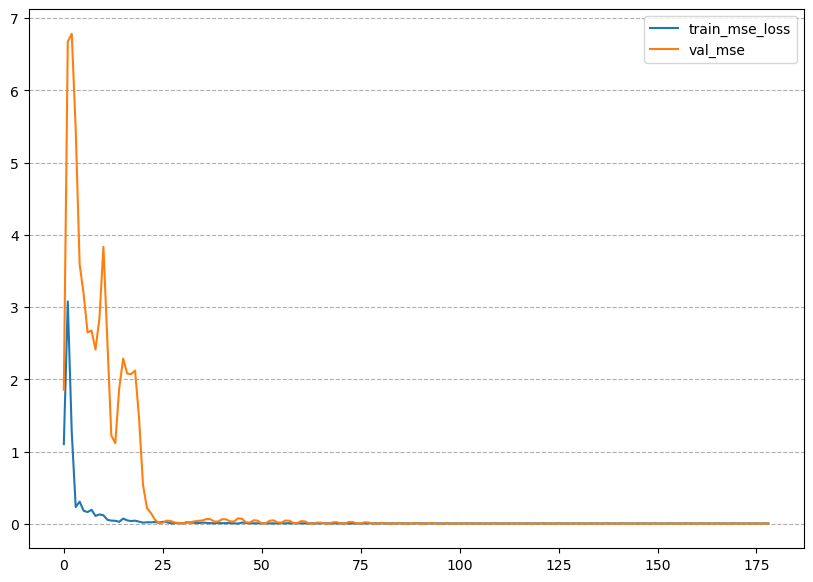

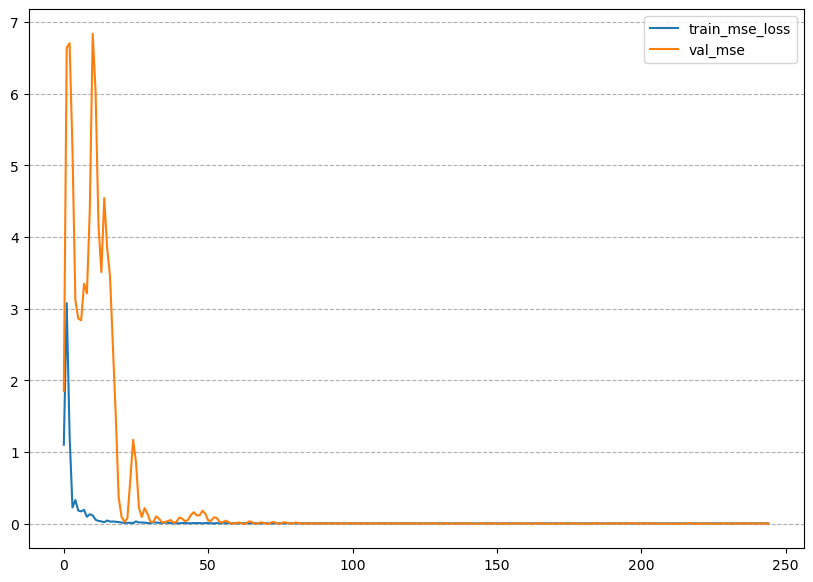

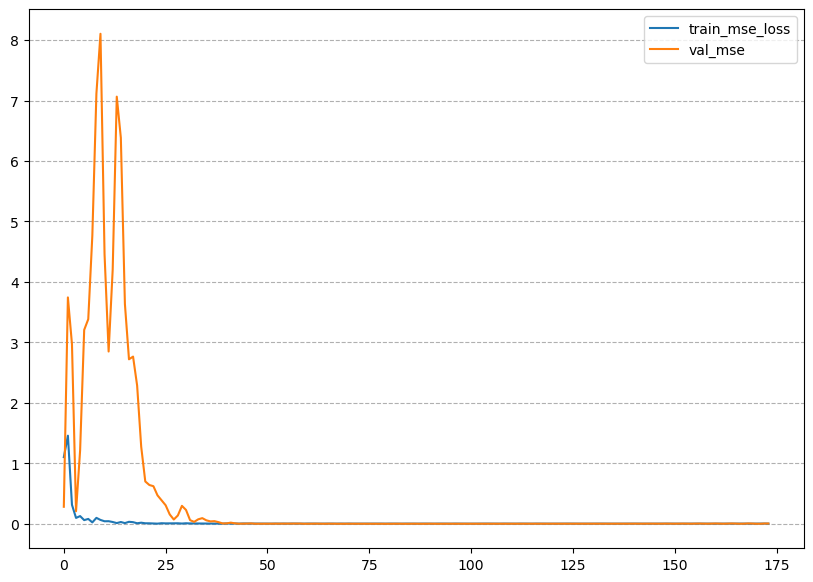

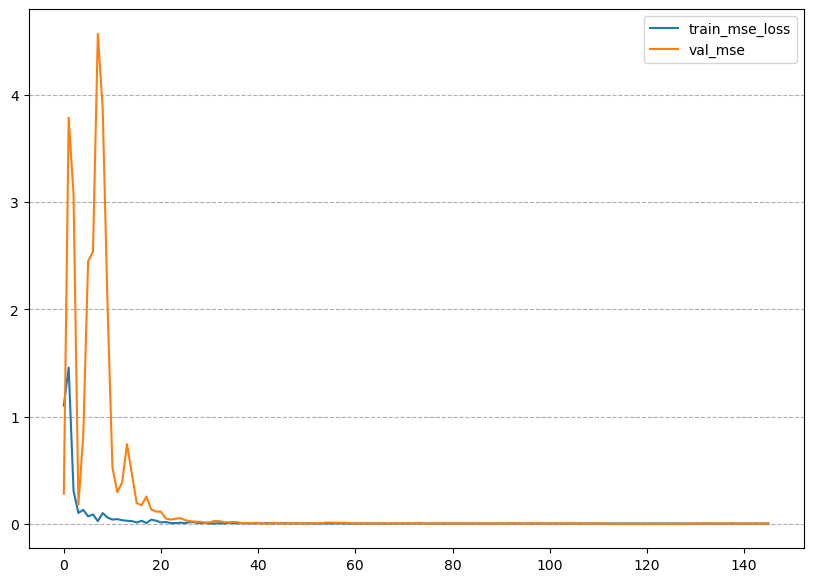

In [25]:
summary = []

## model training with grid search
for lr, clip in product(params, params):

    checker = Checker(model_path)
    trainer = Trainer.from_checker(
        checker=checker,
        cuda=True,
        optimizer=Adam(lr=lr),
        loss_func=MSELoss(),
        clip_grad=ClipValue(clip)
    ).extend(
        TensorConverter(empty_cache=True),
        Validator(metrics_func=regression_metrics, early_stopping=20, trace_order=1, pearsonr=1.0, mse=0.0, r2=0.0, mae=0.0),
    )

    persist = Persist(
        increment=True,
        path=f'generated/transferred_model/model',
        model_class=CrystalGraphConvNet,
        model_params=checker.model_params,
        author='Chang Liu',
        email='liu.chang@ism.ac.jp',
        dataset_detail='vasp-6.1.2'
    )
    trainer.extend(persist).reset(to='mae')


    print(f"====== lr: {lr}; clip: {clip} ===========")
    trainer.fit(training_dataset=train_dataloader, validation_dataset=val_dataloader, epochs=epochs, checkpoint=True)

    persist(splitter=splitter, data_indices=single_point_results.index.tolist())
    training_info = trainer.training_info

    # draw training steps
    f, ax = plt.subplots(figsize=(10, 7),dpi=100)
    ax = trainer.training_info.plot(y=['train_mse_loss', 'val_mse'], ax=ax)
    _ = ax.grid(axis='y', linestyle='--')
    f.savefig(f'{persist.path}/ft_training_steps.png', bbox_inches='tight', dpi=300)

    # draw OvP
    pred, true = trainer.predict(dataset=val_dataloader, checkpoint='mae')
    pred_fit, true_fit = trainer.predict(dataset=train_dataloader, checkpoint='mae')

    _ = cv_plot(pred, true, pred_fit, true_fit)
    plt.savefig(f'{persist.path}/ft_training_plot.png', bbox_inches='tight', dpi=300)
    plt.cla()
    plt.clf()
    plt.close()

    summary.append(dict(
        path=persist.path,
        data_size=data_size,
        lr=lr,
        clip=clip,
        mae=training_info['val_mae'].min(),
        mse=training_info['val_mse'].min(),
        r2=training_info['val_r2'].max(),
        corr=training_info['val_pearsonr'].max(),
    ))
    pd.DataFrame(summary).to_csv('generated/transferred_model/training_summary.pd.csv')

summary = pd.DataFrame(summary)
summary.to_pickle('generated/transferred_model/training_summary.pd.xz')

best_mae = summary.sort_values('mae').iloc[0].path
copyfile(f'{best_mae}/ft_training_plot.png', 'generated/transferred_model/ft_training_best_mae.png')


##### Prediction and virtual screening

In [26]:
N_GROUP = 20
N_OPT = 5

In [27]:
best_mae_path = pd.read_pickle('generated/transferred_model/training_summary.pd.xz').sort_values('mae').iloc[0].path
trainer = Trainer.from_checker(checker=best_mae_path, cuda=True).extend(TensorConverter(empty_cache=True))

### prediction
screen_cgcnn_features = pd.read_pickle('generated/structure_candidate_cgcnn_features.pd')
val_dataloader = DataLoader(CrystalGraphDataset(screen_cgcnn_features, np.zeros(screen_cgcnn_features.shape[0]).reshape(-1, 1)),
                              batch_size=500, collate_fn=CrystalGraphDataset.collate_fn)

pred, _ = trainer.predict(dataset=val_dataloader, checkpoint='mae')

### load screen structures
screen_structures = pd.read_pickle('generated/structure_candidate.pd.xz')
screen_structures = screen_structures.assign(prediction=pred)
screen_structures.drop(columns='structure').to_pickle('generated/structure_candidate_with_prediction.pd.xz')

screen_structures = screen_structures[screen_structures.prediction < 0]
groups = screen_structures.groupby('structure_group')[['dissimilarity', 'prediction']].min().sort_values('prediction').index[:N_GROUP]
opt_candidate = screen_structures[screen_structures.structure_group.isin(groups)].groupby('structure_group').apply(lambda x: x.sort_values('prediction').head(N_OPT)).droplevel('structure_group')
opt_candidate.to_pickle('generated/opt_candidate.pd.xz')

opt_candidate.shape


(89, 6)

### 6. Propose the final candidate

The structure optimization will be applied on the `opt_candidate` structures, and the result will be used to finally propose the possible crystal structures for $\mathrm{Zr}\mathrm{O}_2$. We provide the DFT calculation result again, but users should optimize the structures themselves.

In [28]:
opt_candidate_result = pd.read_pickle('generated/opt_candidate_result.pd.xz')

opt_candidate_result.shape
opt_candidate_result.head(3)

(37, 7)

,formula_pretty,formation_energy_per_atom,final_energy_per_atom,structure_group,target_formula,structure,converged
id,,,,,,,
1059,ZrO2,-7.901437,-9.438405,8,Zr4O8,[[2.61332090e+00 2.61332090e+00 3.20039507e-16...,True
967,ZrO2,-7.901465,-9.438433,8,Zr4O8,[[2.61330891e+00 2.61330891e+00 3.20038039e-16...,True
65,ZrO2,-7.982247,-9.519214,2,Zr4O8,"[[3.66157261 1.3074229 1.49870806] Zr, [1.370...",True


The top 5 structures with the lowest formation energy for each template will be proposed as the final candidate.

In [29]:
final_result = opt_candidate_result.sort_values('formation_energy_per_atom').groupby('structure_group').head(5)
final_result = final_result.assign(
    dissimilarity=calculate_similarity(true_struct, *final_result.structure, n_jobs=1),
    space_group_num=final_result.structure.apply(lambda s: s.get_space_group_info()[1]),
)

final_result.to_pickle('generated/final_proposed_candidate.pd.xz')
final_result

,formula_pretty,formation_energy_per_atom,final_energy_per_atom,structure_group,target_formula,structure,converged,dissimilarity,space_group_num
id,,,,,,,,,
5,ZrO2,-8.056902,-9.593870,0,Zr4O8,"[[2.85272939 3.70408311 4.44153828] Zr, [0.228...",True,0.100232,14
7,ZrO2,-8.056900,-9.593868,0,Zr4O8,"[[2.85291178 3.70391033 4.44185941] Zr, [0.227...",True,0.101241,14
0,ZrO2,-8.056898,-9.593866,0,Zr4O8,"[[2.85307367 3.70349685 4.4420747 ] Zr, [0.227...",True,0.100766,14
2,ZrO2,-8.056889,-9.593857,0,Zr4O8,"[[2.85220447 3.70270231 4.4411749 ] Zr, [0.227...",True,0.100772,14
12,ZrO2,-8.056889,-9.593857,0,Zr4O8,"[[2.85218545 3.70275872 4.44111552] Zr, [0.227...",True,0.100780,14
33,ZrO2,-8.032976,-9.569944,1,Zr4O8,"[[1.35623771 1.22996757 0.1635448 ] Zr, [1.356...",True,0.513832,29
29,ZrO2,-8.032967,-9.569934,1,Zr4O8,"[[1.35621643 1.23036135 0.16409659] Zr, [1.356...",True,0.512709,29
30,ZrO2,-8.032957,-9.569925,1,Zr4O8,"[[1.35670995 1.23153948 0.163581 ] Zr, [1.356...",True,0.513512,29
25,ZrO2,-8.032949,-9.569917,1,Zr4O8,"[[1.35719055 1.23255449 0.16429115] Zr, [1.357...",True,0.512753,29


The proposed structures with id 5, 7, 0, 2, and 12 have the same crystalline structure as the ground truth.